# This notebook contains is used to get the data for the web app

In [6]:
# Modues to be used
import pickle
import numpy as np
import pandas as pd
from datetime import datetime
import time
import urllib.request
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load data from pickle files

# -> Player dictionary with the dataFrames
f = open('data/dict_player.pickle', 'rb')
dict_player = pickle.load(f)

# -> Map dataFrames
f = open('data/df_map.pickle','rb')
df_map = pickle.load(f)

# -> Map dictionary
f = open('data/dict_map.pickle','rb')
dict_map = pickle.load(f)

# Save a list of the teams and their ranks

In [3]:
# All unranked teams make them 420
df_map.loc[ df_map['team_rank_1']==0, 'team_rank_1'] = 420
df_map.loc[ df_map['team_rank_2']==0, 'team_rank_2'] = 420

MAX_RANK = 150

df_aux = df_map[ (df_map['date']>datetime(2019,1,1)) & (df_map['team_rank_1']<MAX_RANK) &  (df_map['team_rank_2']<MAX_RANK) ]

df_1 = df_aux.drop(columns=['map', 'event_id', 'event_name',
       'team_score_1', 'team_kills_1', 'team_deaths_1',
       'team_assists_1','team_id_2', 'team_name_2',
       'team_score_2', 'team_kills_2', 'team_deaths_2', 'team_assists_2',
       'team_rank_2', 'winner']).reset_index()

df_1 = df_1.rename(columns={'team_id_1':'team_id', 'team_name_1':'team_name','team_rank_1':'team_rank'})


df_2 = df_aux.drop(columns=[ 'map', 'event_id', 'event_name',
       'team_score_1', 'team_kills_1', 'team_deaths_1',
       'team_assists_1','team_id_1', 'team_name_1',
       'team_score_2', 'team_kills_2', 'team_deaths_2', 'team_assists_2',
       'team_rank_1', 'winner']).reset_index()

df_2 = df_2.rename(columns={'team_id_2':'team_id', 'team_name_2':'team_name','team_rank_2':'team_rank'})

df = df_1.append(df_2,sort=True,ignore_index=True)

df = df.sort_values('date',ascending=False)

team_id_vec = df.team_id.unique()

dict_team = {}
dict_player_new = {}
for team_id in team_id_vec:
    
    df_tmp = df[ df['team_id'] == team_id].head(n=1)

    dict_team[team_id] = {}
    dict_team[team_id]['team_name'] = df_tmp.team_name.values[0]
    dict_team[team_id]['team_rank'] = df_tmp.team_rank.values[0]
    dict_team[team_id]['team_prize'] = 0.0

    map_id = df_tmp.map_id.values[0]

    count = 0
    for player_id in dict_map[map_id][team_id]['players_id']:

        df_aux = dict_player[player_id][ dict_player[player_id]['date']>datetime(2019,1,1) ]

        prize_money   = df_aux['prize'].sum()
        player_rating = df_aux['rating'].mean()

        dict_player_new[player_id] = {}
        dict_player_new[player_id]['name']        = dict_player[player_id]['player_name'].values[0]
        dict_player_new[player_id]['prize_money'] = prize_money        
        
        dict_player_new[player_id]['rating']           = player_rating
        dict_player_new[player_id]['hs_kills']         = ( (df_aux['hs_kills']/(df_aux['team_score']+df_aux['op_score'])).mean() )
        dict_player_new[player_id]['kills_per_round']  = ( df_aux['kills_per_round'].mean() )
        dict_player_new[player_id]['deaths_per_round'] = ( df_aux['deaths_per_round'].mean() )
        dict_player_new[player_id]['ADR']              = ( df_aux['ADR'].mean() )
        dict_player_new[player_id]['KAST']             = ( df_aux['KAST'].mean() )
        dict_player_new[player_id]['assists']          = ( (df_aux['assists']/(df_aux['team_score']+df_aux['op_score'])).mean() )
        dict_player_new[player_id]['flash_assists']    = ( (df_aux['flash_assists']/(df_aux['team_score']+df_aux['op_score'])).mean() )
        dict_player_new[player_id]['first_kills_diff'] = ( (df_aux['first_kills_diff']/(df_aux['team_score']+df_aux['op_score'])).mean() )
        dict_player_new[player_id]['team_rank']        = ( df_aux['team_rank'].mean() )
        dict_player_new[player_id]['team_score']       = ( (df_aux['team_score']-df_aux['op_score']).mean() )
        dict_player_new[player_id]['win_rate']         = ( df_aux['win'].mean() )

        df_player_maps = df_map.loc[df_aux.index.values]
        op_rank_vec  = (df_aux['team_id']!=df_player_maps['team_id_1'])*df_player_maps['team_rank_1'] + (df_aux['team_id']!=df_player_maps['team_id_2'])*df_player_maps['team_rank_2']

        
        # Scaled variables
        dict_player_new[player_id]['score_dif'] = ( (df_aux['team_score']-df_aux['op_score']).mean() )
        dict_player_new[player_id]['scaled_win']   = ( (df_aux['win']/op_rank_vec).mean() )
        dict_player_new[player_id]['scaled_rating'] = ( (df_aux['rating']/op_rank_vec).mean() )        
        dict_player_new[player_id]['win_rate_map'] = ( (df_aux['win']/op_rank_vec).mean() )
        dict_player_new[player_id]['kd_per_round'] = ( (df_aux['kills_per_round']-df_aux['deaths_per_round']).mean() )
        dict_player_new[player_id]['momentum'] = ( df_aux['win'].head(n=15).mean() )
        
        if prize_money > 0:
            dict_player_new[player_id]['prize_rating'] = np.log( prize_money ) / 12.0
        else:
            dict_player_new[player_id]['prize_rating'] = 0.0

        count = count + 1
        dict_team[team_id]['player_name_'+str(count)] = dict_player[player_id]['player_name'].values[0]
        dict_team[team_id]['player_id_'+str(count)] = dict_player[player_id]['player_id'].values[0]

        dict_team[team_id]['team_prize'] = dict_team[team_id]['team_prize'] + prize_money / 5.0

    if dict_team[team_id]['team_prize'] > 0.0:
        dict_team[team_id]['team_prize_rating'] = np.log( dict_team[team_id]['team_prize'] ) / 12.0
    else:
        dict_team[team_id]['team_prize_rating'] = 0.0



## Construct the average oponent for each team

In [13]:
# Get the rating and prize rating of the average opponent for each team
df = pd.DataFrame.from_dict(dict_team,orient='index')
for team_id in df.index[:]:
    df_aux = df_map[ (df_map['date']>datetime(2019,1,1)) &  ( (df_map['team_id_1']==team_id) | (df_map['team_id_2']==team_id) ) ]

    rating_vec        = []
    prize_vec         = []
    score_dif_vec     = []
    win_rate_vec      = []
    scaled_win_vec    = []
    scaled_rating_vec = [] 
    win_rate_map_vec  = [] 
    kd_per_round_vec  = []
    momentum_vec      = []

    for map_id in df_aux.index:
        
        rating        = []
        prize_rating  = []
        score_dif     = []
        win_rate      = []
        scaled_win    = []
        scaled_rating = [] 
        win_rate_map  = [] 
        kd_per_round  = []
        momentum      = []

        for new_team_id in dict_map[map_id]:
            if( new_team_id != team_id ):
                
                for player_id in dict_map[map_id][new_team_id]['players_id']:

                    try:
                        rating.append( dict_player_new[player_id]['rating'] )

                        prize_rating.append( dict_player_new[player_id]['prize_rating'] )
                        score_dif.append( dict_player_new[player_id]['score_dif'] )
                        win_rate.append( dict_player_new[player_id]['win_rate'] )
                        scaled_win.append( dict_player_new[player_id]['scaled_win'] )
                        scaled_rating.append( dict_player_new[player_id]['scaled_rating'] )
                        win_rate_map.append( dict_player_new[player_id]['win_rate_map'] )
                        kd_per_round.append( dict_player_new[player_id]['kd_per_round'] )
                        momentum.append( dict_player_new[player_id]['momentum'] )

                    except:
                        continue
        
        if len(prize_rating) > 0:
            rating_vec.append( np.mean(rating) )

            prize_vec.append(  np.mean(prize_rating) )
            score_dif_vec.append(  np.mean(score_dif) )
            win_rate_vec.append(  np.mean(win_rate) )
            scaled_win_vec.append(  np.mean(scaled_win) )
            scaled_rating_vec.append(  np.mean(scaled_rating) )
            win_rate_map_vec.append(  np.mean(win_rate_map) )
            kd_per_round_vec.append(  np.mean(kd_per_round) )
            momentum_vec.append(  np.mean(momentum) )
            

    dict_team[team_id]['avg_op_prize_rating']  = np.mean( prize_vec )
    dict_team[team_id]['avg_op_score_dif']     = np.mean( score_dif_vec )
    dict_team[team_id]['avg_op_win_rate']      = np.mean( win_rate_vec )
    dict_team[team_id]['avg_op_scaled_win']    = np.mean( scaled_win_vec )
    dict_team[team_id]['avg_op_scaled_rating'] = np.mean( scaled_rating_vec )
    dict_team[team_id]['avg_op_win_rate_map']  = np.mean( win_rate_map_vec )
    dict_team[team_id]['avg_op_kd_per_round']  = np.mean( kd_per_round_vec )
    dict_team[team_id]['avg_op_momentum']      = np.mean( momentum_vec )

## Save the team data

In [18]:

df = pd.DataFrame.from_dict(dict_team,orient='index')
df = df[ df['team_rank']>0 ]
df = df.sort_values(['team_prize_rating'],ascending=False)

# filename = 'webapp_dict_team_DATA.sav'
# pickle.dump( df, open(filename,'wb') )

df.head(n=10)

## Add the star rating and save the player data

In [4]:
df = pd.DataFrame.from_dict(dict_player_new,orient='index')

df = df.sort_values(['prize_money'],ascending=False)

df_player_aux = df

df.head(n=10)

,name,prize_money,rating,hs_kills,kills_per_round,deaths_per_round,ADR,KAST,assists,flash_assists,...,team_rank,team_score,win_rate,score_dif,scaled_win,scaled_rating,win_rate_map,kd_per_round,momentum,prize_rating
7592,device,359750.000000,1.266101,0.259231,0.785886,0.590000,82.334591,73.359119,0.172389,0.038667,...,1.622642,4.150943,0.742138,4.150943,0.126198,0.230406,0.126198,0.195886,0.800000,1.066097
4954,Xyp9x,359750.000000,1.153648,0.270269,0.679747,0.571139,76.026415,75.623899,0.214533,0.055280,...,1.622642,4.150943,0.742138,4.150943,0.126198,0.208472,0.126198,0.108608,0.800000,1.066097
9032,Magisk,359750.000000,1.199623,0.325160,0.730253,0.600253,81.106918,75.594340,0.195366,0.033972,...,1.622642,4.150943,0.742138,4.150943,0.126198,0.222799,0.126198,0.130000,0.800000,1.066097
7398,dupreeh,359750.000000,1.155220,0.354658,0.718228,0.605949,74.968553,73.676101,0.158102,0.027587,...,1.622642,4.150943,0.742138,4.150943,0.126198,0.209241,0.126198,0.112278,0.800000,1.066097
7412,gla1ve,359750.000000,1.101195,0.286380,0.665759,0.632532,74.671069,70.859119,0.225827,0.066152,...,1.622642,4.150943,0.742138,4.150943,0.126198,0.198053,0.126198,0.033228,0.800000,1.066097
8797,Stewie2K,232041.666667,1.106953,0.306580,0.671631,0.643391,75.139485,70.584979,0.182689,0.049925,...,1.866953,3.339056,0.690987,3.339056,0.098121,0.186108,0.098121,0.028240,0.733333,1.029556
10394,Twistzz,231541.666667,1.172511,0.478346,0.721525,0.582556,74.646188,75.714350,0.152077,0.040362,...,1.950673,3.318386,0.690583,3.318386,0.102020,0.207501,0.102020,0.138969,0.733333,1.029376
8738,EliGE,231541.666667,1.242018,0.405152,0.789372,0.646413,86.518834,71.825561,0.182193,0.035011,...,1.950673,3.318386,0.690583,3.318386,0.102020,0.220451,0.102020,0.142960,0.733333,1.029376
8520,NAF,231541.666667,1.213964,0.309280,0.735631,0.605495,82.978829,74.609910,0.219813,0.065499,...,1.959459,3.315315,0.689189,3.315315,0.102469,0.228075,0.102469,0.130135,0.666667,1.029376
7687,nitr0,229458.333333,1.076968,0.273931,0.648643,0.606923,69.035294,72.698190,0.206850,0.087175,...,1.941176,3.253394,0.683258,3.253394,0.102667,0.193052,0.102667,0.041719,0.666667,1.028623


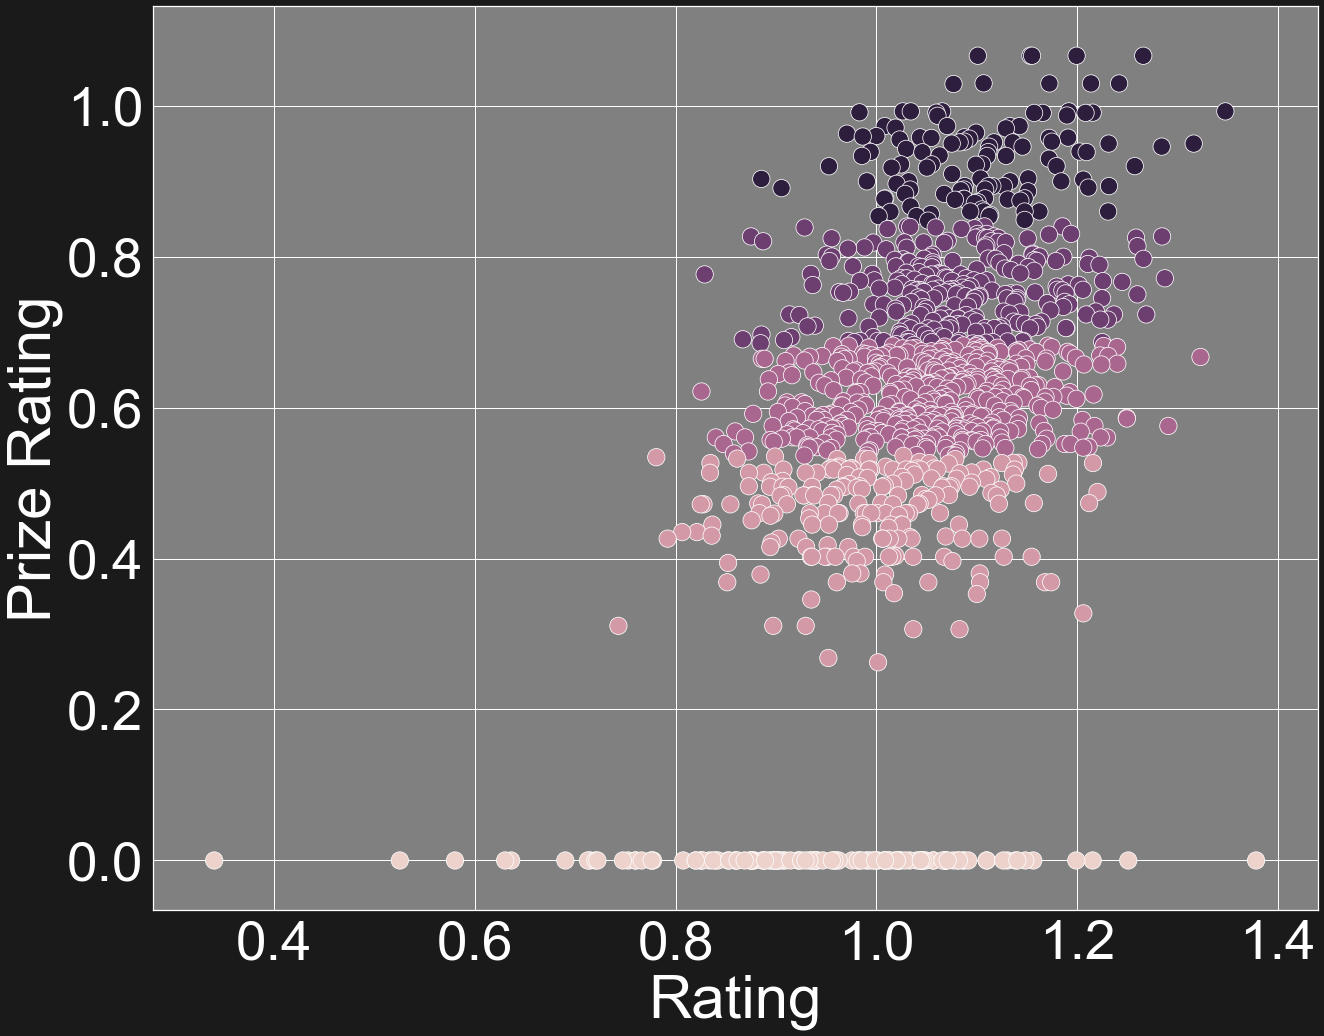

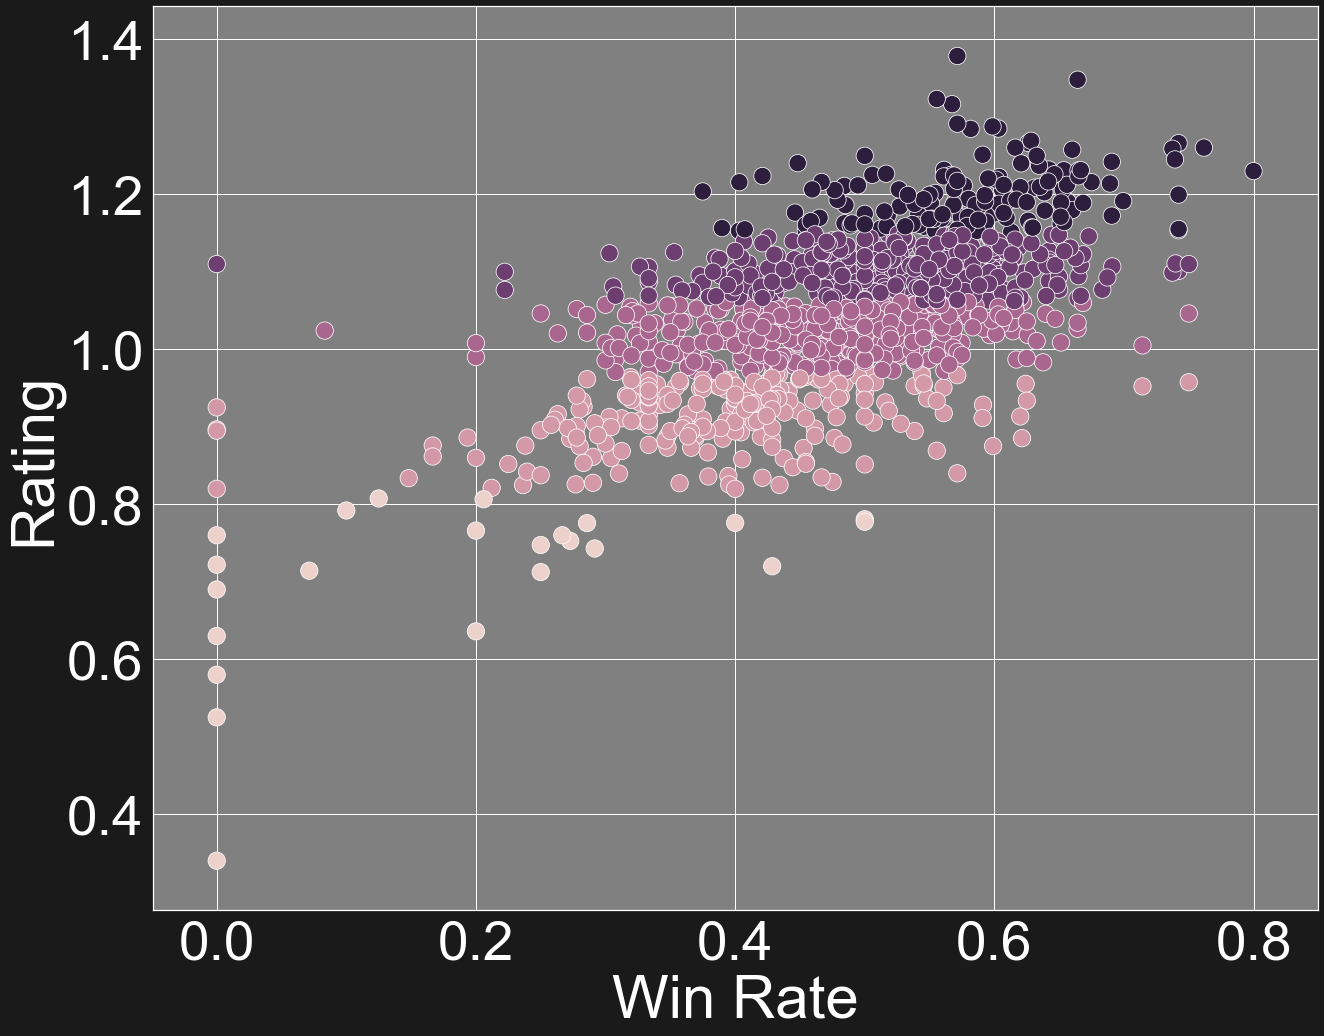

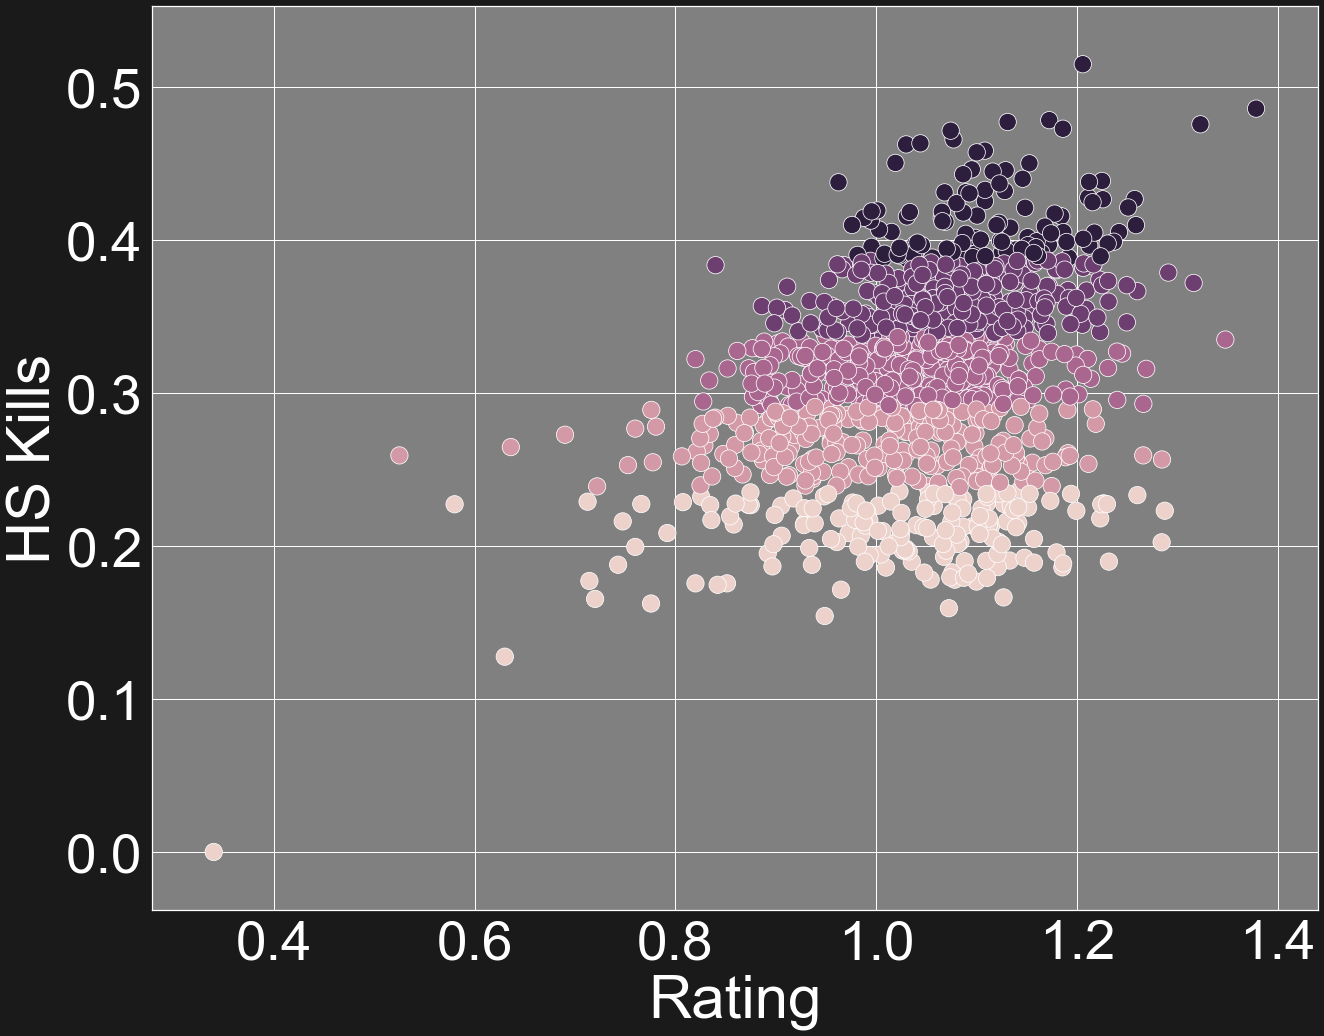

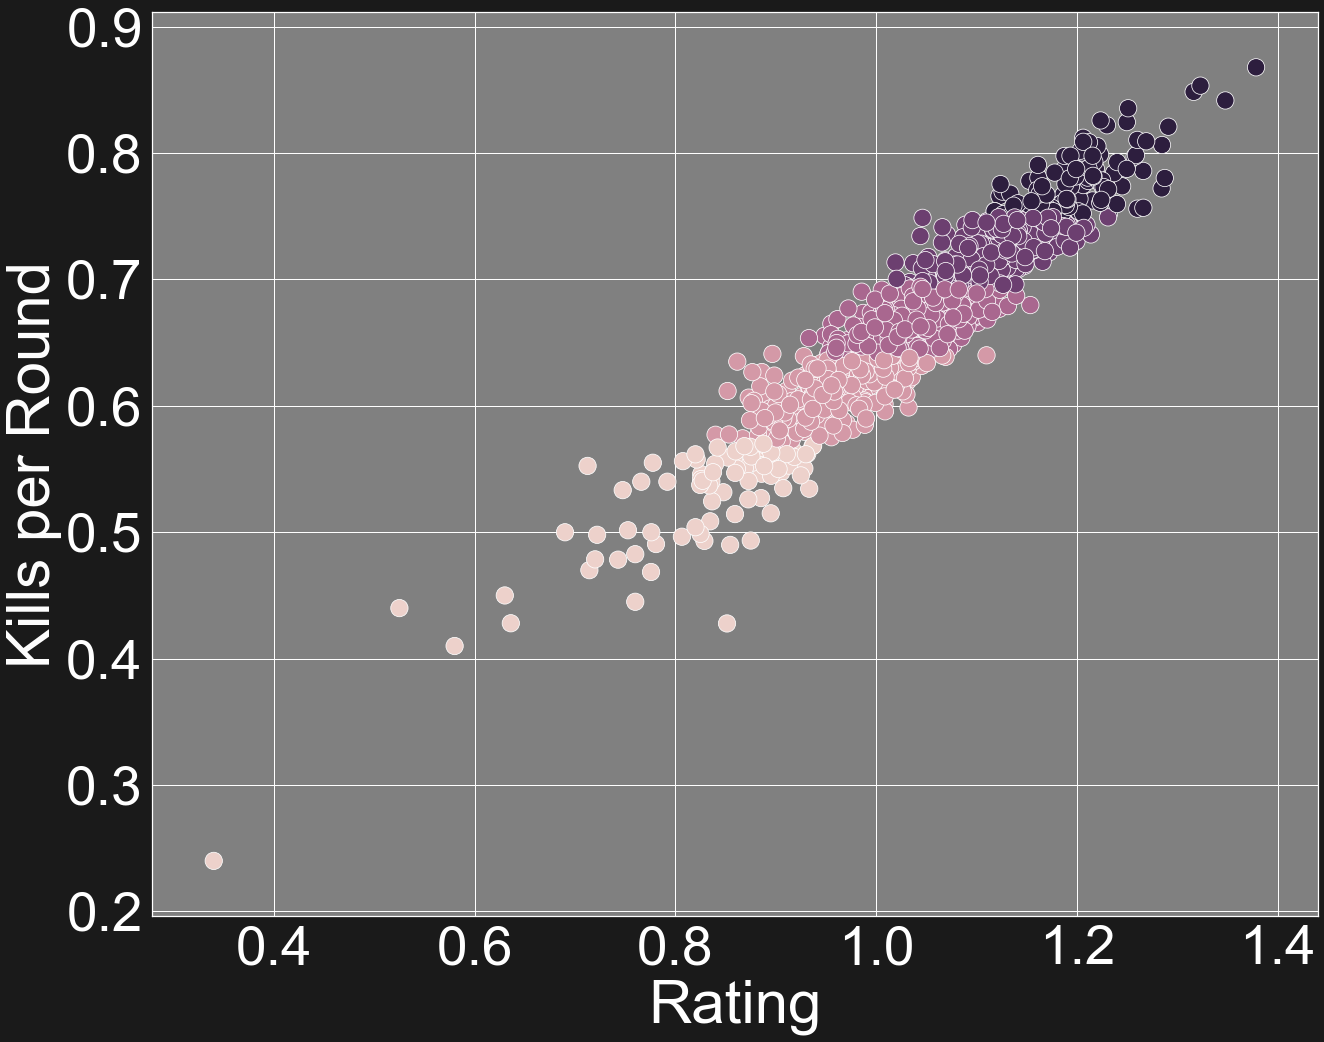

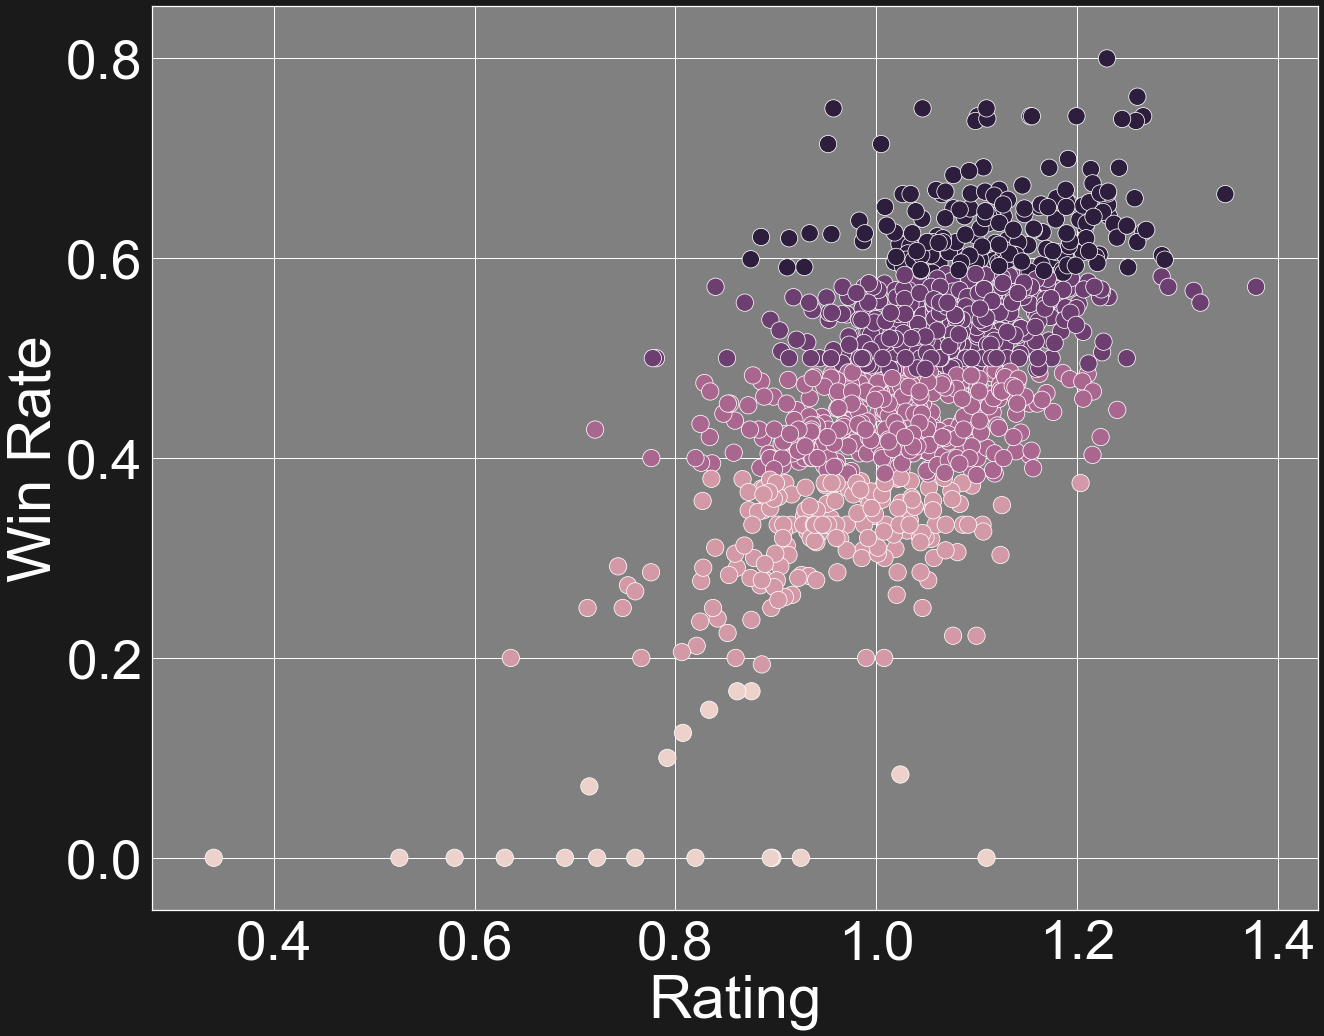

In [31]:
import matplotlib as mpl
from sklearn.cluster import KMeans

df_with_stars = df.copy()

n_clusters = 5

# Add the star ratings for several metics
metrics_vec = ['prize_rating', 'rating', 'hs_kills', 'kills_per_round', 'win_rate']
stars_vec   = ['prize_stars', 'rating_stars', 'hs_stars', 'kills_stars', 'win_stars']

legend_vec = ['Prize Rating','Rating','HS Kills', 'Kills per Round', 'Win Rate']

for ind_met in range( 0, len(metrics_vec) ):

    X = df_with_stars[[metrics_vec[ind_met]]].values
 

    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)

    n = n_clusters
    order = np.argsort( kmeans.cluster_centers_[:,0] )[::-1][:n]

    prize_stars = kmeans.labels_
    for ind in range(0,n_clusters):
        prize_stars[kmeans.labels_==order[ind]] = -5+ind

    df_with_stars[stars_vec[ind_met]] = prize_stars*-1

    sns.set_style("whitegrid")
    sns.set(font_scale=5)

    fig = plt.figure(figsize=(20,16))

    mpl.rcParams.update({'text.color' : "white",
                     'axes.labelcolor' : "white",
                     'xtick.color' : "white",
                     'ytick.color' : "white",
                     'axes.facecolor':"gray"})

    if metrics_vec[ind_met] == 'rating':
        ax = sns.scatterplot(data=df_with_stars,x='win_rate',y=metrics_vec[ind_met],hue=stars_vec[ind_met],s=300,legend=False)
        plt.xlabel('Win Rate')

    else:
        ax = sns.scatterplot(data=df_with_stars,x='rating',y=metrics_vec[ind_met],hue=stars_vec[ind_met],s=300,legend=False)
        plt.xlabel('Rating')

    # plt.(legend_vec[ind_met]+' Stars')

    plt.ylabel(legend_vec[ind_met])

    ax.set_facecolor('gray')
    fig.set_facecolor('k')
    plt.tight_layout()

    plt.savefig(stars_vec[ind_met]+'.png', transparent=True, bbox_inches="tight")

In [ ]:
# # Save the player data
# filename = 'webapp_dict_player_DATE.sav'
# pickle.dump( df_with_stars, open(filename,'wb') )